## 1. Load packages

In [1]:
# data processing packages
import numpy as np
from numpy import random
import pandas as pd
import re

# machine learning packages
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import Isomap
from sklearn.tree import DecisionTreeClassifier
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list

# visualization packages
import seaborn as sb
import matplotlib.pyplot as plt

# other packages
import torch
from pathlib import Path
import random
import itertools
import time


import warnings
warnings.filterwarnings("ignore")


## 2. Read the files

In [2]:
## Create the necessary folders
Path('./Figures/').mkdir(parents=True, exist_ok=True)
Path('./Results/').mkdir(parents=True, exist_ok=True)

In [3]:
## Set path to the data set
dataset_path = "./dataset/77_cancer_proteomes_CPTAC_itraq.csv"
clinical_info = "./dataset/clinical_data_breast_cancer.csv"
pam50_proteins = "./dataset/PAM50_proteins.csv"

## Load data
data = pd.read_csv(dataset_path,header=0,index_col=0)
clinical_file = pd.read_csv(clinical_info,header=0,index_col=0) ## holds clinical information about each patient/sample
pam50 = pd.read_csv(pam50_proteins,header=0)

# RefSeq protein ID (each protein has a unique ID in a RefSeq database)
print(data.index.name)
data

RefSeq_accession_number


,gene_symbol,gene_name,AO-A12D.01TCGA,C8-A131.01TCGA,AO-A12B.01TCGA,BH-A18Q.02TCGA,C8-A130.02TCGA,C8-A138.03TCGA,E2-A154.03TCGA,C8-A12L.04TCGA,...,AO-A12B.34TCGA,A2-A0SW.35TCGA,AO-A0JL.35TCGA,BH-A0BV.35TCGA,A2-A0YM.36TCGA,BH-A0C7.36TCGA,A2-A0SX.36TCGA,263d3f-I.CPTAC,blcdb9-I.CPTAC,c4155b-C.CPTAC
RefSeq_accession_number,,,,,,,,,,,,,,,,,,,,,
NP_958782,PLEC,plectin isoform 1,1.096131,2.609943,-0.659828,0.195341,-0.494060,2.765081,0.862659,1.407570,...,-0.963904,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.398560,0.598585,-0.191285,0.566975
NP_958785,NaN,plectin isoform 1g,1.111370,2.650422,-0.648742,0.215413,-0.503899,2.779709,0.870186,1.407570,...,-0.938210,-0.487772,-0.10668,-0.055893,0.658143,-0.547749,-0.392601,0.606697,-0.183918,0.578702
NP_958786,PLEC,plectin isoform 1a,1.111370,2.650422,-0.654285,0.215413,-0.500619,2.779709,0.870186,1.410312,...,-0.943919,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_000436,NaN,plectin isoform 1c,1.107561,2.646374,-0.632113,0.205377,-0.510459,2.797995,0.866423,1.407570,...,-0.935355,-0.487772,-0.10668,-0.055893,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_958781,NaN,plectin isoform 1e,1.115180,2.646374,-0.640428,0.215413,-0.503899,2.787023,0.870186,1.413053,...,-0.935355,-0.503853,-0.10668,-0.062523,0.651264,-0.556675,-0.395581,0.603993,-0.167079,0.576747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NP_001191293,NaN,protein FAM24B precursor,NaN,NaN,NaN,-16.029761,1.729692,4.107251,-9.584499,-5.196859,...,-6.662350,NaN,NaN,NaN,NaN,NaN,NaN,-8.020071,-3.093822,-4.602418
NP_775791,NaN,putative uncharacterized protein C9orf62,NaN,NaN,NaN,-2.046065,-0.425182,-3.203370,-4.786183,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.049608,-0.646977,0.240590
NP_004065,COX8A,"cytochrome c oxidase subunit 8A, mitochondrial",NaN,NaN,NaN,-1.778435,-0.149673,1.971481,-3.103949,-0.933726,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Data Set Processing

In [4]:
## Drop unused information columns
data.drop(['gene_symbol','gene_name'],axis=1,inplace=True)

## Change the protein data sample names to a format matching the clinical data set
data.rename(columns=lambda x: "TCGA-%s" % (re.split('[_|-|.]',x)[0]) if bool(re.search("TCGA",x)) is True else x,inplace=True)

data.head()

,TCGA-AO-A12D,TCGA-C8-A131,TCGA-AO-A12B,TCGA-BH-A18Q,TCGA-C8-A130,TCGA-C8-A138,TCGA-E2-A154,TCGA-C8-A12L,TCGA-A2-A0EX,TCGA-AO-A12D,...,TCGA-AO-A12B,TCGA-A2-A0SW,TCGA-AO-A0JL,TCGA-BH-A0BV,TCGA-A2-A0YM,TCGA-BH-A0C7,TCGA-A2-A0SX,263d3f-I.CPTAC,blcdb9-I.CPTAC,c4155b-C.CPTAC
RefSeq_accession_number,,,,,,,,,,,,,,,,,,,,,
NP_958782,1.096131,2.609943,-0.659828,0.195341,-0.494060,2.765081,0.862659,1.407570,1.185108,1.100688,...,-0.963904,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.398560,0.598585,-0.191285,0.566975
NP_958785,1.111370,2.650422,-0.648742,0.215413,-0.503899,2.779709,0.870186,1.407570,1.192612,1.100688,...,-0.938210,-0.487772,-0.10668,-0.055893,0.658143,-0.547749,-0.392601,0.606697,-0.183918,0.578702
NP_958786,1.111370,2.650422,-0.654285,0.215413,-0.500619,2.779709,0.870186,1.410312,1.188860,1.100688,...,-0.943919,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_000436,1.107561,2.646374,-0.632113,0.205377,-0.510459,2.797995,0.866423,1.407570,1.185108,1.100688,...,-0.935355,-0.487772,-0.10668,-0.055893,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_958781,1.115180,2.646374,-0.640428,0.215413,-0.503899,2.787023,0.870186,1.413053,1.200116,1.093358,...,-0.935355,-0.503853,-0.10668,-0.062523,0.651264,-0.556675,-0.395581,0.603993,-0.167079,0.576747


In [5]:
## Transpose data for the clustering algorithm since we want to divide patient samples, not proteins
print(data.shape)
datat = data.transpose()
print(datat.shape)

datat.head()

(12553, 83)
(83, 12553)


RefSeq_accession_number,NP_958782,NP_958785,NP_958786,NP_000436,NP_958781,NP_958780,NP_958783,NP_958784,NP_112598,NP_001611,...,NP_001193600,NP_061134,NP_932347,NP_003593,NP_997203,NP_001191293,NP_775791,NP_004065,NP_068752,NP_219494
TCGA-AO-A12D,1.096131,1.111370,1.111370,1.107561,1.115180,1.107561,1.111370,1.111370,-1.517390,0.482754,...,NaN,NaN,NaN,-0.340163,NaN,NaN,NaN,NaN,-0.633517,12.666488
TCGA-C8-A131,2.609943,2.650422,2.650422,2.646374,2.646374,2.646374,2.650422,2.650422,3.909313,-1.045294,...,NaN,NaN,NaN,3.451902,NaN,NaN,NaN,NaN,4.840325,0.140736
TCGA-AO-A12B,-0.659828,-0.648742,-0.654285,-0.632113,-0.640428,-0.654285,-0.648742,-0.648742,-0.618256,1.222003,...,NaN,NaN,NaN,-1.718531,NaN,NaN,NaN,NaN,-1.965192,-2.854835
TCGA-BH-A18Q,0.195341,0.215413,0.215413,0.205377,0.215413,0.215413,0.215413,0.215413,-1.035760,-0.517226,...,0.048144,NaN,-0.881872,2.527072,-8.111243,-16.029761,-2.046065,-1.778435,NaN,-3.069752
TCGA-C8-A130,-0.494060,-0.503899,-0.500619,-0.510459,-0.503899,-0.503899,-0.500619,-0.500619,-1.845366,-0.405503,...,1.457462,NaN,1.710012,0.296389,-1.753529,1.729692,-0.425182,-0.149673,NaN,-0.047997


In [6]:
print("Number of patients in clinical data set: ", len(clinical_file.index))
print("Number of patients in protein data set: ", len(datat.index))

Number of patients in clinical data set:  105
Number of patients in protein data set:  83


In [7]:
## Drop clinical entries for samples not in our protein data set
clinical = clinical_file.loc[[x for x in clinical_file.index.tolist() if x in datat.index],:]

print("The shape of the clinical data set: ", clinical.shape)
clinical

The shape of the clinical data set:  (77, 29)


,Gender,Age at Initial Pathologic Diagnosis,ER Status,PR Status,HER2 Final Status,Tumor,Tumor--T1 Coded,Node,Node-Coded,Metastasis,...,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
Complete TCGA ID,,,,,,,,,,,,,,,,,,,,,
TCGA-A2-A0CM,FEMALE,40,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,...,Basal-like,-12,-13,4,4,Basal,4,2,1,1
TCGA-BH-A18Q,FEMALE,56,Negative,Negative,Negative,T2,T_Other,N1,Positive,M0,...,Basal-like,-12,-13,5,5,Basal,1,2,2,2
TCGA-A7-A0CE,FEMALE,57,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,...,Basal-like,0,-13,5,5,Basal,1,2,2,2
TCGA-D8-A142,FEMALE,74,Negative,Negative,Negative,T3,T_Other,N0,Negative,M0,...,Basal-like,0,-13,3,5,X,1,2,2,2
TCGA-AO-A0J6,FEMALE,61,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,...,Basal-like,-12,-13,2,5,Basal,1,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AR-A1AV,MALE,68,Positive,Positive,Negative,T2,T_Other,N1,Positive,M0,...,Luminal B,-5,-2,7,3,LumA/B,3,4,4,5
TCGA-BH-A0C7,FEMALE,48,Positive,Negative,Positive,T2,T_Other,N1,Positive,M0,...,Luminal B,-3,0,4,4,LumA/B,5,4,1,3
TCGA-BH-A0DD,MALE,58,Positive,Positive,Positive,T2,T_Other,N1,Positive,M0,...,Luminal B,-3,-6,4,4,LumA/B,3,4,1,3


In [8]:
## Add clinical meta data to our protein data set, note: all numerical features for analysis start with NP_ or XP_
merged = datat.merge(clinical,left_index=True,right_index=True)

# Drop the duplicated columns (added by Pietro Gavazzi)
liste = merged.index.copy()
liste = list(liste)

for i in np.unique(merged.index):
    liste.remove(i)

## Change name to make it look nicer in the code!
processed = merged.drop(np.unique(liste))

print("Shape of the merged data set: ", processed.shape)
print("with %d patients and %d features" % (processed.shape[0], processed.shape[1]))

processed.head()

Shape of the merged data set:  (74, 12582)
with 74 patients and 12582 features


,NP_958782,NP_958785,NP_958786,NP_000436,NP_958781,NP_958780,NP_958783,NP_958784,NP_112598,NP_001611,...,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
TCGA-A2-A0CM,0.683404,0.694424,0.698098,0.687077,0.687077,0.698098,0.698098,0.698098,-2.652150,-0.984373,...,Basal-like,-12,-13,4,4,Basal,4,2,1,1
TCGA-A2-A0D2,0.107491,0.104164,0.107491,0.097512,0.104164,0.104164,0.104164,0.104164,-0.880454,-1.512473,...,Basal-like,-12,-13,4,5,Basal,3,2,2,2
TCGA-A2-A0EQ,-0.912670,-0.927979,-0.927979,-0.931806,-0.927979,-0.927979,-0.927979,-0.927979,-3.071151,-2.278943,...,HER2-enriched,-5,-2,5,4,Basal,4,4,1,1
TCGA-A2-A0EV,0.452986,0.472590,0.472590,0.458587,0.472590,0.472590,0.472590,0.472590,-0.742871,1.811277,...,Luminal A,-4,0,4,2,ReacI,3,3,3,4
TCGA-A2-A0EX,1.185108,1.192612,1.188860,1.185108,1.200116,1.188860,1.188860,1.192612,1.046289,2.138081,...,Luminal A,-7,-5,4,4,ReacI,4,3,1,4


In [9]:
## Numerical data for the algorithm, NP_xx/XP_xx are protein identifiers from RefSeq database
X = processed.loc[:,[x for x in processed.columns if bool(re.search("NP_|XP_|YP_",x)) == True]]
Y = pd.get_dummies(processed.drop(X.columns, axis=1)['Integrated Clusters (with PAM50)'], prefix="PAM50")

## Select only the PAM50 proteins - known panel of genes used for breast cancer subtype prediction
# processed_numerical_p50 = processed_numerical.iloc[:,processed_numerical.columns.isin(pam50['RefSeqProteinID'])]
# processed_numerical_p50.head()

X.columns

Index(['NP_958782', 'NP_958785', 'NP_958786', 'NP_000436', 'NP_958781',
       'NP_958780', 'NP_958783', 'NP_958784', 'NP_112598', 'NP_001611',
       ...
       'NP_001193600', 'NP_061134', 'NP_932347', 'NP_003593', 'NP_997203',
       'NP_001191293', 'NP_775791', 'NP_004065', 'NP_068752', 'NP_219494'],
      dtype='object', length=12553)

In [10]:
Y.head()

,PAM50_1,PAM50_2,PAM50_3,PAM50_4
TCGA-A2-A0CM,0,1,0,0
TCGA-A2-A0D2,0,1,0,0
TCGA-A2-A0EQ,0,0,0,1
TCGA-A2-A0EV,0,0,1,0
TCGA-A2-A0EX,0,0,1,0


In [11]:
# Save the data
torch.save(X, './Results/X')
torch.save(Y, './Results/Y')

## 3. Data Engineering

In [12]:
# Read the processed data set
X = torch.load('./Results/X')
Y = torch.load('./Results/Y')

In [13]:
X.head()

,NP_958782,NP_958785,NP_958786,NP_000436,NP_958781,NP_958780,NP_958783,NP_958784,NP_112598,NP_001611,...,NP_001193600,NP_061134,NP_932347,NP_003593,NP_997203,NP_001191293,NP_775791,NP_004065,NP_068752,NP_219494
TCGA-A2-A0CM,0.683404,0.694424,0.698098,0.687077,0.687077,0.698098,0.698098,0.698098,-2.652150,-0.984373,...,NaN,NaN,1.153614,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-A2-A0D2,0.107491,0.104164,0.107491,0.097512,0.104164,0.104164,0.104164,0.104164,-0.880454,-1.512473,...,0.919136,-1.648856,0.832649,NaN,-8.324969,-4.679219,NaN,-1.106650,NaN,-6.941181
TCGA-A2-A0EQ,-0.912670,-0.927979,-0.927979,-0.931806,-0.927979,-0.927979,-0.927979,-0.927979,-3.071151,-2.278943,...,-0.801685,NaN,NaN,3.802310,-6.373934,-1.123160,NaN,NaN,NaN,NaN
TCGA-A2-A0EV,0.452986,0.472590,0.472590,0.458587,0.472590,0.472590,0.472590,0.472590,-0.742871,1.811277,...,-4.966177,-1.471027,NaN,-0.474013,-12.278546,-10.337729,-0.653251,NaN,NaN,NaN
TCGA-A2-A0EX,1.185108,1.192612,1.188860,1.185108,1.200116,1.188860,1.188860,1.192612,1.046289,2.138081,...,1.451490,-2.018981,0.877456,NaN,NaN,-6.101005,NaN,-1.726336,NaN,NaN


In [14]:
Y.head()

,PAM50_1,PAM50_2,PAM50_3,PAM50_4
TCGA-A2-A0CM,0,1,0,0
TCGA-A2-A0D2,0,1,0,0
TCGA-A2-A0EQ,0,0,0,1
TCGA-A2-A0EV,0,0,1,0
TCGA-A2-A0EX,0,0,1,0


### 3.1 Missing value process
We drop all the columns with nan values

In [15]:
nan_counts = np.sum(X.isna(), axis=0)
col_to_drop = nan_counts[nan_counts != 0].index
X.drop(col_to_drop, axis=1, inplace=True)

In [16]:
X.shape

(74, 8023)

### 3.2 Data Scaling
We use the standardization for each feature of the data set

In [17]:
col_names = X.columns
idx = X.index
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=col_names, index=idx)
X_scaled.shape

(74, 8023)

In [18]:
X_scaled

,NP_958782,NP_958785,NP_958786,NP_000436,NP_958781,NP_958780,NP_958783,NP_958784,NP_112598,NP_001611,...,NP_001652,NP_071753,NP_001294,NP_065775,NP_001094348,XP_003846524,NP_443073,NP_001004456,NP_997625,NP_003270
TCGA-A2-A0CM,0.452431,0.457240,0.461851,0.454087,0.449388,0.461992,0.462014,0.461871,-1.154705,-0.927883,...,0.044546,-0.965931,0.677192,0.362810,-0.448672,0.278981,-0.212651,0.434459,-0.183720,0.450670
TCGA-A2-A0D2,-0.172432,-0.181569,-0.177678,-0.185102,-0.181181,-0.181168,-0.180454,-0.180530,-0.262565,-1.283112,...,0.780823,0.803122,0.274983,0.640327,0.336494,-0.556361,-0.097150,-0.132248,0.073308,0.166313
TCGA-A2-A0EQ,-1.279303,-1.298605,-1.298919,-1.301058,-1.297708,-1.298859,-1.296940,-1.296900,-1.365693,-1.798682,...,0.779414,0.489079,0.336844,0.928380,0.638359,0.067456,0.325932,-0.109886,-0.094616,0.004053
TCGA-A2-A0EV,0.202429,0.217160,0.217664,0.206365,0.217365,0.217794,0.218079,0.217961,-0.193284,0.952625,...,0.392444,0.600195,0.721871,0.920962,-1.391716,-1.922260,0.473734,1.559915,-0.154031,-1.207976
TCGA-A2-A0EX,0.996779,0.996403,0.993265,0.994038,1.004370,0.993431,0.992880,0.996740,0.707650,1.172451,...,0.777902,0.828705,0.845406,0.301582,-0.061610,0.251906,0.428227,1.128522,1.486423,0.941278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-C8-A138,2.711043,2.714039,2.715889,2.742683,2.721017,2.716135,2.717684,2.717306,1.291391,0.238750,...,-1.915083,-1.072697,-0.528912,-0.570562,0.774013,1.149504,-1.650540,-0.149274,-1.312052,-0.234429
TCGA-D8-A142,0.295315,0.292507,0.293051,0.289189,0.292678,0.293185,0.293388,0.293263,0.106161,-0.085811,...,0.596749,1.741597,0.734238,0.423549,0.241682,0.089117,1.604141,1.521944,1.118896,-0.334321
TCGA-E2-A154,0.646923,0.647458,0.648194,0.648529,0.647467,0.648344,0.648165,0.648002,1.147694,1.314459,...,0.540979,-0.460462,-1.040990,-0.542866,-0.580825,-0.931097,0.500013,1.758582,0.266633,-0.300594
TCGA-E2-A158,-1.467939,-1.479897,-1.480308,-1.478522,-1.478917,-1.477830,-1.475718,-1.475660,0.229446,-1.038804,...,0.403608,-0.114534,0.753064,-0.238230,0.690123,0.557149,-0.250745,-0.112657,-0.280932,1.171750


In [19]:
Y

,PAM50_1,PAM50_2,PAM50_3,PAM50_4
TCGA-A2-A0CM,0,1,0,0
TCGA-A2-A0D2,0,1,0,0
TCGA-A2-A0EQ,0,0,0,1
TCGA-A2-A0EV,0,0,1,0
TCGA-A2-A0EX,0,0,1,0
...,...,...,...,...
TCGA-C8-A138,1,0,0,0
TCGA-D8-A142,0,1,0,0
TCGA-E2-A154,0,0,1,0
TCGA-E2-A158,0,1,0,0


## 4. Basic model

### 4.1 K-Means model

In [20]:
kmeans = KMeans(n_clusters=4, algorithm='full').fit(X_scaled)
pred0 = kmeans.labels_

### 4.2 Evaluation Metric

In [21]:

# https://medium.com/data-science-in-your-pocket/calculating-precision-recall-for-multi-class-classification-9055931ee229 


permutation_matrices = []
for i in itertools.permutations([0, 1, 2, 3]):
    matrix = np.zeros((4, 4))
    for j in range(len(matrix)):
        matrix[j][i[j]] = 1

    permutation_matrices.append(matrix)



def get_dataframe(y_array_pred, y_true):
    pred = pd.DataFrame(pd.get_dummies(y_array_pred))
    pred.columns = ['cluster_' + str(x) for x in range(1, 5)]
    pred = pred.set_index(y_true.index)
    return(pred)



def calculate_mean_prec(matrix):
    matrix = np.array(matrix)
    assert(matrix.shape[0]==matrix.shape[1]), f"matrix must be squared, same number of true labels {matrix.shape[0]} as predicted{matrix.shape[1]}"

    prec = np.zeros(len(matrix))

    for i in range(len(matrix)):
        true_pos_classified_pos = matrix[i][i]
        classified_pos= np.sum(matrix[i])
        prec[i] = true_pos_classified_pos/classified_pos
    
    return np.mean(prec)

def calculate_mean_recall(matrix):
    matrix = np.array(matrix)
    assert(matrix.shape[0]==matrix.shape[1]), f"matrix must be squared, same number of true labels {matrix.shape[0]} as predicted{matrix.shape[1]}"

    rec = np.zeros(len(matrix.T))

    for i in range(len(matrix.T)):
        true_pos_classified_pos = matrix.T[i][i]
        true_pos= np.sum(matrix.T[i])
        rec[i] = true_pos_classified_pos/true_pos

    return np.mean(rec)


def model_eval(y_true, y_pred):

    length = len(y_true.T)
    assert (y_pred.shape==y_true.shape), f"expected same shape of colums for both y_true: {y_true.shape} and y_pred {y_pred.shape}"
    
    matrix = np.zeros((length, length))

    indi = 0
    for i in y_pred.T.index:
        indj = 0
        for j in y_true.T.index:
            matrix[indi][indj] += np.array(y_pred[i]) @ np.array(y_true[j])
            indj+=1
        indi+=1

    
    matrix = pd.DataFrame(matrix, columns=y_true.T.index, index=y_pred.T.index)


    best_perm = None
    best_Fscore = 0
    best_prec = 0
    best_rec = 0

    ## version 3.0
    for permu_mat in permutation_matrices:
        M = permu_mat@matrix

        prec = calculate_mean_prec(M)
        rec = calculate_mean_recall(M)

        Fscore = 2/(1/prec + 1/rec)
        
        if Fscore > best_Fscore:
            best_perm = permu_mat
            best_Fscore = Fscore
            best_prec = prec
            best_rec = rec
    
    new_matrix = best_perm@matrix

    indexes = []
    for i in range(len(best_perm)):
        for j in range(len(best_perm)):
            if best_perm[i][j]==1:
                indexes.append(matrix.index[j])


    new_matrix.index = indexes

    return new_matrix, best_Fscore, best_prec, best_rec

In [22]:
y_pred = get_dataframe(pred0, Y)
new_matrix, best_Fscore, best_prec, best_rec = model_eval(Y, y_pred)
new_matrix

,PAM50_1,PAM50_2,PAM50_3,PAM50_4
cluster_3,4.0,0.0,2.0,3.0
cluster_4,3.0,10.0,3.0,6.0
cluster_2,1.0,4.0,13.0,6.0
cluster_1,2.0,4.0,5.0,8.0


In [23]:
best_Fscore

0.4662869382003349

## 5. Model improvement

### 5.1 Feature selection

#### 5.1.1 One feature only

In [ ]:

Fscor_list = []
max_Fscore = 0
feature_selected = None

for i in range(X_scaled.shape[1]):
    print(str(i)+"/"+str(8022))
    X_reduced = np.array(X_scaled.iloc[:, i]).reshape(-1, 1)
    k_means = KMeans(n_clusters=4).fit(X_reduced)
    pred_ = k_means.labels_
    y_pred_ = get_dataframe(pred_, Y)
    _, Fscore = model_eval(Y, y_pred_)
    Fscor_list.append(Fscore)

    if Fscore > max_Fscore:
        max_Fscore = Fscore
        feature_selected = X_scaled.columns[i]

print(max_Fscore)
print(feature_selected)

#### 5.1.2 PCA on all the features

In [ ]:
fscore_list = []
explained_variance = []
n_components_list = np.arange(2, 75)
for n_components in n_components_list:
    # print(n_components)
    pca = PCA(n_components=n_components)
    pca.fit(X_scaled)
    X_reduced = pca.transform(X_scaled)
    kmeans = KMeans(n_clusters=4, algorithm='full').fit(X_reduced)
    pred_ = kmeans.labels_
    y_pred = get_dataframe(pred_, Y)
    _, best_Fscore, best_prec, best_rec = model_eval(Y, y_pred)
    fscore_list.append(best_Fscore)
    explained_variance.append(pca.explained_variance_ratio_)



In [ ]:
y_max = np.max(fscore_list) # 0.5989
x_max = (np.argmax(fscore_list) + 2) # 67
x = n_components_list

plt.figure(figsize=(16, 8))
plt.plot(x, fscore_list, label='PCA clustering results')
plt.plot([x_max], [y_max], 'ro', markersize=8, color='r', label='maximum')
plt.ylabel('F-score', fontdict={'fontsize':14})
plt.xlabel('Number of componenets', fontdict={'fontsize':14})
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=12)
plt.legend()
plt.savefig('./Figures/PCA_feature_selection.pdf')
plt.show()



In [ ]:
# #test  PCA

# fscore_list = []
# explained_variance = []
# n_components_list = np.arange(2, 75)

# for i in range(49):
#     print(i)
#     GX = np.random.normal(0, 1, X_scaled.shape)
#     for n_components in n_components_list:
#         # print(n_components)
#         pca = PCA(n_components=n_components)
#         pca.fit(GX)
#         X_reduced = pca.transform(GX)
#         kmeans = KMeans(n_clusters=4, algorithm='full').fit(X_reduced)
#         pred_ = kmeans.labels_
#         y_pred = get_dataframe(pred_, Y)
#         _, best_Fscore, best_prec, best_rec = model_eval(Y, y_pred)
#         fscore_list.append(best_Fscore)
#         explained_variance.append(pca.explained_variance_ratio_)



In [ ]:
# fscore_list = np.array(fscore_list)

# print(max(fscore_list))
# plt.hist(fscore_list, 50)
# plt.xlim([0, 1])
# plt.title("Histogram of Fscores when performing 49 times the pca test with random data")
# plt.xlabel("F-score")

#### 5.1.3 Kernel PCA

In [24]:
fscore_list_kernel = []
n_components_list = np.arange(2, 300)
for n_components in n_components_list:
    # print(n_components)
    kpca = KernelPCA(n_components=n_components, kernel='rbf')
    kpca.fit(X_scaled)
    X_reduced = kpca.transform(X_scaled)
    kmeans = KMeans(n_clusters=4, algorithm='full').fit(X_reduced)
    pred_ = kmeans.labels_
    y_pred = get_dataframe(pred_, Y)
    _, best_Fscore, best_prec, best_rec = model_eval(Y, y_pred)
    fscore_list_kernel.append(best_Fscore)

KeyboardInterrupt: 

In [ ]:
y_max = np.max(fscore_list_kernel) # 0.6213
x_max = (np.argmax(fscore_list_kernel) + 2) # 183
x = n_components_list

plt.figure(figsize=(16, 8))
plt.plot(x, fscore_list_kernel, label='Kernel PCA clustering results')
plt.plot([x_max], [y_max], 'ro', markersize=8, label='maximum')
plt.ylabel('F-score', fontdict={'fontsize':14})
plt.xlabel('Number of componenets', fontdict={'fontsize':14})
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=12)
plt.legend()
plt.savefig('./Figures/KPCA_feature_selection.pdf')
plt.show()

In [33]:
# test k-PCA 
fscore_list_kernel = []

for i in range(49):
    print(i)
    GX = np.random.normal(0, 1, X_scaled.shape)
    n_components_list = np.arange(2, 300)
    for n_components in n_components_list:
        # print(n_components)
        kpca = KernelPCA(n_components=n_components, kernel='rbf')
        kpca.fit(GX)
        X_reduced = kpca.transform(GX)
        kmeans = KMeans(n_clusters=4, algorithm='full').fit(X_reduced)
        pred_ = kmeans.labels_
        y_pred = get_dataframe(pred_, Y)
        _, best_Fscore, best_prec, best_rec = model_eval(Y, y_pred)
        fscore_list_kernel.append(best_Fscore)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


In [34]:
len(fscore_list_kernel)

14602

0.5231923281400078


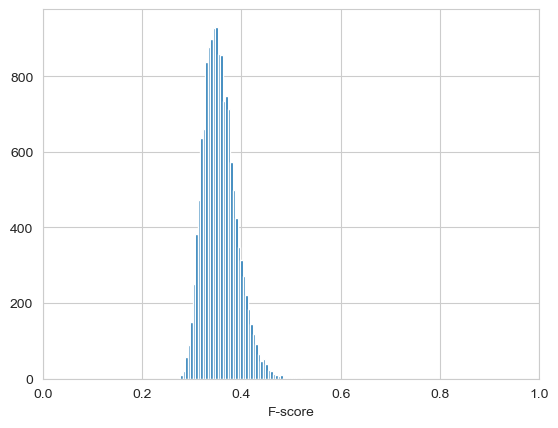

In [35]:
fscore_list_kernel = np.array(fscore_list_kernel)
print(max(fscore_list_kernel))
plt.hist(fscore_list_kernel, 50)
plt.xlim([0, 1])
# plt.title("Histogram of F-scores when performing 49 times the kernel pca test with random data")
plt.xlabel("F-score")
plt.savefig("./Figures/hist.pdf")
plt.show()

### 5.2 Hierarchical Clustering

#### 5.2.1 Hierarchical Clustering based on PCA 67 dimensions

In [ ]:
# import matplotlib as mpl
# mpl.rcParams.update({'font.size': 20})
pca = PCA(n_components=67)
pca.fit(X_scaled)
X_reduced = pca.transform(X_scaled)
plt.figure(figsize=(16, 10), dpi=100)
linkage_data = linkage(X_reduced, method='ward', metric='euclidean')
dendrogram(linkage_data)
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=12)
plt.xlabel('Patients', fontdict={'fontsize':15})
plt.ylabel('Distance', fontdict={'fontsize':15})
plt.savefig('./Figures/dendro_pca.pdf')
plt.show()

In [ ]:
leaves_list(linkage_data).tolist()

In [ ]:
c1 = [65, 62, 23, 25, 54]
c2 = [57, 56, 14, 31, 11, 44, 68, 70, 3, 50, 58, 10, 47, 28, 71, 53, 60, 6, 36, 8, 22, 4, 9, 12, 32, 7, 35, 51]
c3 = [2, 49, 63, 45, 64, 26, 29, 61, 15, 40, 72, 67, 1, 59, 0, 52]
c4 = [27, 34, 42, 5, 46, 17, 73, 24, 69, 55, 13, 20, 37, 18, 39, 41, 33, 38, 43, 19, 48, 30, 66, 16, 21]

In [ ]:
Y_copy = Y.copy()
Y_copy['ind'] = np.arange(Y_copy.shape[0])
pred_hier = Y_copy['ind'].apply(lambda x: 0 if x in c1 else 1 if x in c2 else 2 if x in c3 else 3)

In [ ]:
y_pred = get_dataframe(pred_hier, Y)
_, best_Fscore, best_prec, best_rec = model_eval(Y, y_pred)

In [ ]:
best_Fscore

#### 5.2.2 Hierarchical Clustering based on KPCA 183 dimensions

In [ ]:
# import matplotlib as mpl
# mpl.rcParams.update({'font.size': 20})
kpca = KernelPCA(n_components=183)
kpca.fit(X_scaled)
X_reduced = kpca.transform(X_scaled)
plt.figure(figsize=(16, 10), dpi=100)
linkage_data = linkage(X_reduced, method='ward', metric='euclidean')
dendrogram(linkage_data)
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=12)
plt.xlabel('Patients', fontdict={'fontsize':15})
plt.ylabel('Distance', fontdict={'fontsize':15})
plt.savefig('./Figures/dendro_kpca.pdf')
plt.show()

In [ ]:
leaves_list(linkage_data).tolist()

In [ ]:
c1 = [7, 36, 6, 51, 57, 56, 14, 31, 4, 9, 32, 12, 35]
c2 = [65, 11, 44, 68, 70, 3, 50, 58, 10, 47, 28, 71, 23, 25, 54, 62, 53, 21, 60, 8, 22]
c3 = [2, 49, 63, 45, 52, 64, 26, 29, 67, 1, 59, 40, 72, 0, 15]
c4 = [27, 34, 42, 5, 46, 17, 61, 73, 24, 69, 55, 13, 20, 37, 18, 39, 41, 33, 38, 43, 19, 48, 16, 30, 66]

In [ ]:
Y_copy = Y.copy()
Y_copy['ind'] = np.arange(Y_copy.shape[0])
pred_hier_2 = Y_copy['ind'].apply(lambda x: 0 if x in c1 else 1 if x in c2 else 2 if x in c3 else 3)
y_pred = get_dataframe(pred_hier_2, Y)
_, Fscore, prec, rec = model_eval(Y, y_pred)

In [ ]:
Fscore